In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import jsonlines
from spacy import displacy
from spacy.symbols import nsubj, VERB
from spacy.pipeline import EntityRuler
from spacy.matcher import Matcher
from spacy.tokens import Span

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk import ngrams

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#carregar as bases
df1 = pd.read_excel("Vagas por site 05.2022.xlsx")

df1['len'] = df1['descrição completa'].str.len()
df1 = df1[df1['len']>300].reset_index()

jobs = df1['descrição completa']
cargos = df1['title']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               1093 non-null   int64 
 1   descrição completa  1093 non-null   object
 2   title               1093 non-null   object
 3   site                1093 non-null   object
 4   len                 1093 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 42.8+ KB


In [3]:
#pacote de funções
class job_skills_parser:

    def __init__(self,nlp):
        nlp=nlp
        config = {"phrase_matcher_attr": None, "validate": True,
                  "overwrite_ents": False, "ent_id_sep": "||", }

        ruler = nlp.add_pipe("entity_ruler", config=config)
        ruler.from_disk('padrões')
        self.rules = ruler.patterns
        
    def update_patterns(self,new_patterns):
        ruler.add_patterns(patterns)
        self.rules = ruler.patterns
        ruler.to_disk('padrões')

    def fit_text(self, text):
        text = text.lower()
        text = text.replace('.', '. ')
        text = text.replace(',', ', ')
        text = text.replace(';', '; ')
        text = text.replace(':', ': ')
        text = text.replace(' . ', ' ')
        text = text.replace('  ', ' ')
        self.doc = nlp(text)

    def show_skills(self):
        displacy.render(self.doc, style="ent", jupyter=True)

    def get_skills(self):
        skills = [(ent.text, ent.label_)
                  for ent in self.doc.ents
                  if ent.label_ in ['JOB_DESC', 'hard_skills', 'formação', 'extra_skills', 'sistemas', 'experiencia','linguagens']]

        return skills



# Usando o modelo

In [31]:
#carregando o modelo com a inguagem PT large
nlp = spacy.load("pt_core_news_lg")
modelo = job_skills_parser(nlp)

Encontrando skills nos textos.
pipe: 

1) fit_text('texto da vaga',type=string)
   
2) usar as funções para de extração de features (skills)
   a) show_skills: cria um visual destacando os skills encontrados
   b) get_skills: cria uma lista de tuples com as skills encontradas
            
3) vc também pode comparar um texto com outro para ver as similaridades entre os skills encontrados, por exemplo,      comparar uma vaga de emprego com um currículo para ver o quão aderente são. para isso utilize a função comparecompare_skills -> função abandonada por compliance e respeito à LGPD

In [44]:
#encontrando skills em uma das vagas de emprego da Catho
modelo.fit_text(jobs[540])
modelo.show_skills()
modelo.get_skills()

[('sql', 'linguagens'),
 ('atuação em modelo hibrido e disponibilidade', 'JOB_DESC'),
 ('sql', 'linguagens'),
 ('sql', 'linguagens'),
 ('experiência com sql', 'experiencia'),
 ('experiência em criptografia do', 'experiencia'),
 ('sql', 'linguagens'),
 ('conhecimento sobre ambientes', 'hard_skills'),
 ('azure', 'sistemas'),
 ('conhecimento de mysql', 'hard_skills'),
 ('postgresql', 'sistemas'),
 ('oracle', 'sistemas'),
 ('inglês avançado', 'hard_skills'),
 ('alinhamento com o líder', 'JOB_DESC')]

# TFIDF Analysis

Load datasets

In [32]:
df = pd.read_excel("Vagas por site 11.2022.xlsx")
d = {}
for n in df['title']:
    if n in d:
        d[n] = d[n] + 1
    else:
        d[n] = 1
    
d

{'analista de controladoria': 739}

In [33]:
df1 = df[(df['title'] == 'analista de controladoria')]

df1['len'] = df1['descrição completa'].str.len()
df1 = df1[df1['len']>300].reset_index()

jobs = df1['descrição completa']
cargos = df1['title']
sites = df1['site']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               558 non-null    int64 
 1   descrição completa  558 non-null    object
 2   title               558 non-null    object
 3   site                558 non-null    object
 4   len                 558 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 21.9+ KB


Extrar os skills para cada uma das vagas do dataset, criando um novo DataFrame

In [34]:
all_skills = {'skills':[],'tipo':[],'site':[],'cargo':[]}
n=0
for job in jobs:
    modelo.fit_text(job)
    for skill,tipo in modelo.get_skills():
        all_skills['skills'].append(skill)
        all_skills['tipo'].append(tipo)
        all_skills['site'].append(sites[n])
        all_skills['cargo'].append(cargos[n])
    n+=1
all_skills = pd.DataFrame(all_skills)     

In [49]:
bad_words = ['gender', 'experience', 'application', 'Apply', 'salary', 'todos', 'os', 'company', 'identity', 'sexual', 'orientation',
            'de', 'orientação', 'sexual', 'gênero', 'committed', 'toda', 'client', 'conhecimento','completo',
            'world', 'year', 'save', 'São', 'Paulo', 'information', 'e', 'orientação', 'sexual', 'equal', 'oppotunity', 'ambiente', 'will',
            'Experiência', 'national origin', 'todas', 'work', 'de', 'da', 'years', 'pessoa', 'clients', 'Plano', 'creating',
            'employer', 'saúde', 'em', 'working', 'pessoas', 'mais', 'data', 'people', 'dia', 'one', 'knowledges', 'plataforma',
            'ou', 'benefício', 'para', 'software', 'opportunity', 'tecnologia', 'você', 'mais', 'solution', 'national', 'origin',
            'trabalhar', 'option', 'negócio', 'empresa', 'o', 'sicence', 'team', 'é', 'veteran', 'status', 'etc', 'raça', 'cor', 'belive',
            'nossa', 'uma', 'como', 'Scientist', 'ferramenta', 'projeto', 'que', 'job', 'benefícios', 'knowledge', 'toll', 's',
            'desconto', 'cultura', 'serviço', 'time', 'se', 'solutions', 'mercado', 'das', 'somos', 'problema', 'mundo', 'race', 'color',
            'vaga', 'pelo', 'ser', 'show', 'Seguro', 'Se', 'um', 'Um', 'tool', 'regard', 'without', 'make', 'ao', 'técnica', 'life',
            'interested', 'diversidade', 'proud', 'ability', 'sobre', 'options', 'using', 'área', 'nosso', 'na', 'seu', 'product', 'produto',
            'building', 'skill', 'model', 'religion', 'Share', 'receive', 'consideration', 'Aqui', 'vida', 'ferramentas', 'Vale', 'Refeição',
            'Strong', 'Pay', 'range', 'available', 'part', 'trabalho', 'Alimentação', 'employment', 'qualified', 'applicants', 'gympass',
            'está', 'comprometida', 'forma', 'Transporte', 'Yes', 'gente', 'melhor', 'lugar', 'believe', 'moment', 'próximo', 'deasafio',
             'fazer','apuração','apurar','atuação','atuar','realização','realizar','elaoração','elaborar',
            'planejamento','planejar','apoio','apoiar','facilidade','revisão','revisar','execução','executar',
            'análise','analisar','validação','validar','participação','participar','confecção','confeccionar',
            'consolidação','consolidar','desenvolvimento','desenvolver','criação','criar','auxílio','avançado','intermediário'
            'auxiliar','acompanhamento','acompanhar','controle','controlar','revisão','revisar','básico','fluente',
            'formação','formação','formar','graduação','graduar','superior','cursar','cursando','graduação','graduar',
            'vivencia','vivência','atuar','atuação','experiencia','experiência','conhecimento','conhecer','habilidade',
            'dos', 'oportunidade', 'idade', 'new', 'Try', 'Premium', 'deficiência', 'sempre', 'criar', 'employee', 'problemas', 'unavailable',
            'Brasil', 'dado', 'hiring', 'trends', 'equipe', 'recent', 'temos', 'build', 'career', 'nós', 'diferencial', 'ma',
            'total', 'oferecemos', 'contato', 'tem', 'não', 'free', 'Full','of','to','is','avançado','conhecimentos',

            'capacidade','entendimento','entender','facilidade','avançado','intermediário','intermediario','basico']

stopw = 'de a o que e do da em um para é com não uma os no se na por mais as dos como mas foi ao ele das tem à seu sua ou ser quando muito há nos já está eu também só pelo pela até isso ela entre era depois sem mesmo aos ter seus quem nas me esse eles estão você tinha foram essa num nem suas meu às minha têm numa pelos elas havia seja qual será nós tenho lhe deles essas esses pelas este fosse dele tu te vocês vos lhes meus minhas teu tua teus tuas nosso nossa nossos nossas dela delas esta estes estas aquele aquela aqueles aquelas isto aquilo estou está estamos estão estive esteve estivemos estiveram estava estávamos estavam estivera estivéramos esteja estejamos estejam estivesse estivéssemos estivessem estiver estivermos estiverem hei há havemos hão houve houvemos houveram houvera houvéramos haja hajamos hajam houvesse houvéssemos houvessem houver houvermos houverem houverei houverá houveremos houverão houveria houveríamos houveriam sou somos são era éramos eram fui foi fomos foram fora fôramos seja sejamos sejam fosse fôssemos fossem for formos forem serei será seremos serão seria seríamos seriam tenho tem temos tém tinha tínhamos tinham tive teve tivemos tiveram tivera tivéramos tenha tenhamos tenham tivesse tivéssemos tivessem tiver tivermos tiverem terei terá teremos terão teria teríamos teriam'.split()

stopw = [*stopw,*bad_words]

In [50]:
def tokenize(text):
    WNLTokens = []
    chars = []
    
    WNLemmatizer = WordNetLemmatizer()
    for ch in text:
        if ch not in string.punctuation:
            chars.append(ch)
        else:
            chars.append(' ')
    txt = ''.join(chars)        
        
    tokens = word_tokenize(txt)
    for t in tokens:
        WNLTokens.append(WNLemmatizer.lemmatize(t))
    
    return WNLTokens

def get_frequency(countvec,sent_list):
    
    dtm = countvec.fit_transform(sent_list)
    word_list = countvec.get_feature_names()

    # Added [0] here to get a 1d-array for iteration by the zip function. 
    count_list = np.asarray(dtm.sum(axis=0))[0]

    word_vec = pd.DataFrame(zip(word_list, count_list))
    word_vec = word_vec.sort_values(1,ascending=False)
    word_vec = word_vec.rename(columns={0:'word',1:'frequency'})
    
    return word_vec

In [51]:
#definir os CountVectorizers
Cont = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(1, 2))
ContV = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(1, 1))
ContV2 = CountVectorizer(max_df=0.95,min_df=2,stop_words=stopw,tokenizer=tokenize,ngram_range=(2, 2))

Extrair a frequencia das palavras (unigram e bigram) de cada skill e montar um novo DataFrame para os graficos de barra

In [52]:
df_skills = pd.DataFrame()
n=0
for skill_type in list(set(all_skills['tipo'])):

    try:
        result1 = get_frequency(ContV,all_skills[all_skills['tipo'] == skill_type]['skills'])
        result1['tipo'] = skill_type
        result1['ngram'] = 'unigram'
    
        result2 = get_frequency(ContV2,all_skills[all_skills['tipo'] == skill_type]['skills'])
        result2['tipo'] = skill_type
        result2['ngram'] = 'bigram'
    except: pass
    n+=1
    
    df_skills = pd.concat([df_skills,result1,result2],ignore_index=True)

C:\Users\caiozas\Anaconda39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alimentação', 'applicant', 'apply', 'aqui', 'brasil', 'es', 'forum', 'full', 'paulo', 'pay', 'plano', 'premium', 'refeição', 'scientist', 'seguro', 'share', 'strong', 'transporte', 'trend', 'try', 'vale', 'yes'] not in stop_words.
  warnings.warn(
C:\Users\caiozas\Anaconda39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\caiozas\Anaconda39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alimentação', 'applicant', 'apply', 'aqui', 'brasil'

In [53]:
set(df_skills['tipo'])

{'JOB_DESC',
 'experiencia',
 'formação',
 'hard_skills',
 'linguagens',
 'sistemas'}

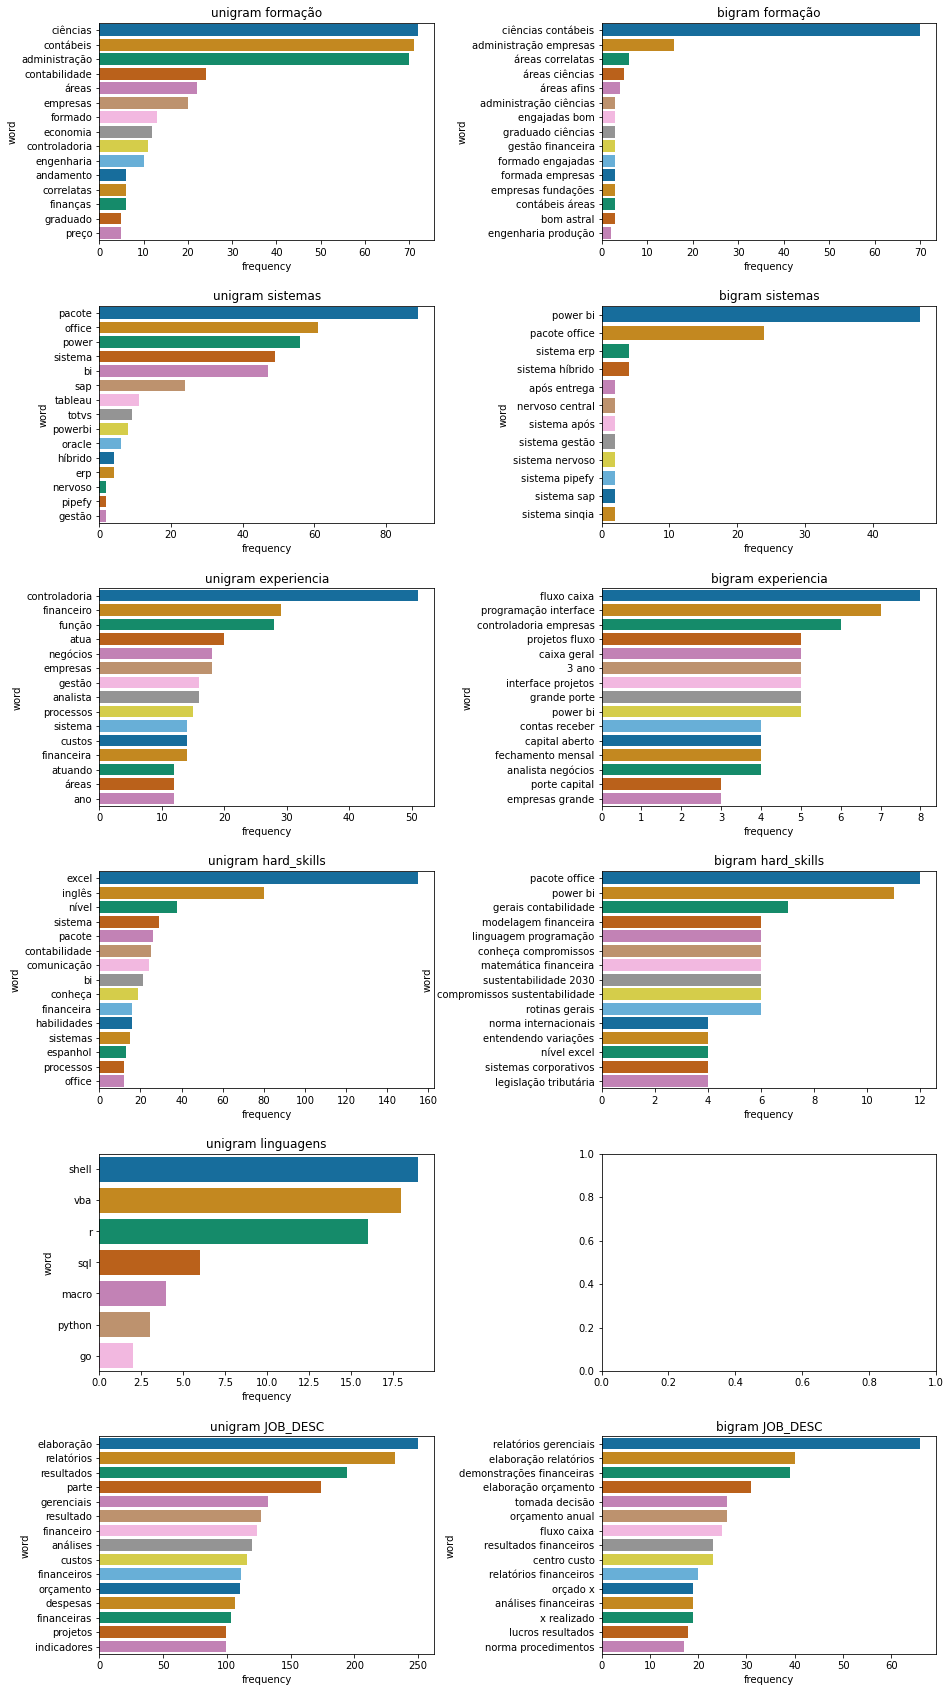

In [54]:
ntipos = list(set(df_skills['tipo']))

fig, axes = plt.subplots(len(ntipos),2,figsize=(15,30))
plt.subplots_adjust(wspace=.5,hspace=.3)
n=0

#gerar um grafico de barras de unigram e outro de bigram para cada tipo de skills extraido
for tipo in ntipos:
    df = df_skills[((df_skills['tipo'] == tipo) & (df_skills['ngram'] == 'unigram'))]
    sns.barplot(ax=axes[n][0],data=df.head(15),x='frequency',y='word',palette='colorblind').set_title(f'unigram {tipo}')
    #Dificilmente teremos um bigram para linguagem de programação
    if tipo != 'linguagens':
        df = df_skills[((df_skills['tipo'] == tipo) & (df_skills['ngram'] == 'bigram'))]
        sns.barplot(ax=axes[n][1],data=df.head(15),x='frequency',y='word',palette='colorblind').set_title(f'bigram {tipo}')
    n+=1

In [ ]:
df_sites = pd.DataFrame()
for site in list(set(all_skills['site'])):
    df_filter_site = all_skills[all_skills['site'] == site]
    
    for tipo in list(set(df_filter_site['tipo'])):
        try:
            result = get_frequency(ContV,df_filter_site[df_filter_site['tipo'] == tipo]['skills'])
            result['tipo'] = tipo
            result['site'] = site
        except: pass
    
   
        df_sites = pd.concat([df_sites,result],ignore_index=True)
    


In [ ]:
nsites = list(set(df_sites['site']))
ntipos = list(set(df_sites['tipo']))

fig, axes = plt.subplots(len(ntipos),2,figsize=(15,30))
plt.subplots_adjust(wspace=.5,hspace=.3)

c=0
for site in nsites:
    r=0
    for tipo in ntipos:
        df = df_sites[((df_sites['tipo'] == tipo) & (df_sites['site'] == site))]
        sns.barplot(ax=axes[r][c],data=df.head(20),x='frequency',y='word',palette='colorblind').set_title(f'{site} {tipo}')
        r+=1
    c+=1

In [ ]:
df_sites2 = pd.DataFrame()

for site in list(set(all_skills['site'])):
    df_filter_site = all_skills[all_skills['site'] == site]
    
    for tipo in list(set(df_filter_site['tipo'])):
        try:
            result = get_frequency(ContV2,df_filter_site[df_filter_site['tipo'] == tipo]['skills'])
            result['tipo'] = tipo
            result['site'] = site
        except: pass
  
   
        df_sites2 = pd.concat([df_sites2,result],ignore_index=True)

# Calibrar os padrões

In [40]:
patterns = [{'label': 'JOB_DESC',
  'pattern': [{'LEMMA': {'IN': [
      'fazer',
      'parametrizar','parametrização',
      'cadastro', 'cadastrar',
      'emissão','emitir',
      'apuração','apurar',
      'atuação','atuar',
      'realização','realizar',
      'elaboração','elaborar',
      'planejamento','planejar',
      'apoio','apoiar',
      'facilidade',
      'revisão','revisar',
      'execução','executar',
      'análise','analisar',
      'validação','validar',
      'participação','participar',
      'confecção','confeccionar',
      'consolidação','consolidar',
      'desenvolvimento','desenvolver',
      'criação','criar',
      'auxílio','auxiliar',
      'acompanhamento','acompanhar',
      'alinhamento','alinhar',
      'apresentação','apresentar',
      'controle','controlar','controlo',
      'revisão','revisar'
      ]}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET','NOUN', 'ADJ','ADV', 'PROPN','CCONJ',]},'OP': '+'}
             ]},
            
            
 {'label': 'formação',
  'pattern': [{'LEMMA': {'IN': ['formação',
      'formação','formar',
      'graduação','graduar',
      'superior',
      'cursar','cursando',
      'graduação','graduar'
      ]}},
   {'LOWER': {'IN': [
       'superior',
      'completo',''
      'cursando',
      'graduação',
      ]},
    'OP': '*'},
   {'POS': 'ADP'},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'CCONJ']},
    'OP': '+'}]},
            
            
 {'label': 'experiencia',
  'pattern': [{'LEMMA': {'IN': [
      'vivencia','vivência',
      'atuar','atuação',
      'experiencia','experiência'
        ]}},              
   {'POS': {'IN': ['ADP', 'DET']}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'NUM','CCONJ']},
    'OP': '+'}]},
            
 {'label': 'hard_skills',
  'pattern': [{'LEMMA': {'IN': [
      'conhecimento','conhecer',
      'habilidade',
      'capacidade',
      'entendimento','entender',
      'facilidade'
        ]}},
   {'POS': {'IN': ['ADP', 'DET']}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'NUM']},
    'OP': '+'}]},
            
            
 {'label': 'hard_skills',
  'pattern': [{'IS_PUNCT': False},
   {'LOWER': {'IN': [
      'avançado',
      'intermediário',
      'intermediario',
      'basico',
      'básico',
      'fluente'
   ]}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN']},
    'OP': '*'}]},
            
            
 {'label': 'sistemas',
  'pattern': [{'LOWER': {'IN': ['power',
    'PBI',
    'powerbi',
    'sap',
    'totvs',
    'tableau',
    'pacote',
    'hyperion',
    'office',
    'azure',
    'mysql',
    'mariadb',    
    'oracle',
    'postgresql',
    'neo4j',
    'spss'
                 
            ]}},  
   {'LOWER': {'IN': ['bi',
      'powerbi',
      'sap',
      'totvs',
      'tableau',
      'office',
      'point',
      'query']},
    'OP': '*'}]},
            
 {'label': 'sistemas',
  'pattern': [{'LOWER': 'sistema'},
   {'POS': {'IN': ['VERB', 'ADP', 'NOUN', 'ADJ', 'PROPN']}, 'OP': '+'}]},

            
 {'label': 'linguagens',
  'pattern': [{'LOWER': {'IN': [

    'dax',
    'python',
    'vba',
    'macro',
    'sql',
    'javascript',
    'html',
    'java',
    'c#',
    'c++',
    'php',
    'Ruby',
    'css',
    'typescript',
    'swift',
    'objective-C',
    'Scala',
    'r',
    'go',
    'shell',
    'powerShell',
    'perl',
    'kotlin',
    'haskell'      
  ]}}  
   ]}]





In [41]:
nlp = spacy.load("pt_core_news_lg")
nlp=nlp
config = {"phrase_matcher_attr": None, "validate": True,
                  "overwrite_ents": False, "ent_id_sep": "||", }

ruler = nlp.add_pipe("entity_ruler", config=config)
ruler.add_patterns(patterns)
ruler.to_disk('padrões')